<a href="https://colab.research.google.com/github/ProxMaq/ProxVision/blob/main/TRR%20%26%20CDI/CDI/Coins_classification_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <b> Indian Coins Classification Task <b></h1>

#### Notebook will require GPU 

In [ ]:
#check if we have GPU available
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices(),'\n\n')

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12369322108796089635
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16185556992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12861155224799472132
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
] 


Default GPU Device: /device:GPU:0


## Define Dataset Path variables 

In [ ]:
#define Variables
DATA_DIR = "/content/drive/MyDrive/currency/indian_coins_dataset"
TRAINING_DIR = "/content/drive/MyDrive/currency/indian_coins_dataset/Train"
VALIDATION_DIR = "/content/drive/MyDrive/currency/indian_coins_dataset/Validate"

In [ ]:
#make dir in current working dir to store few generated outputs during training process
!mkdir output 

#define output variable
OUTPUT_DIR = '/content/output'

In [ ]:
!mkdir '/content/output/plots'


## Required Libraries

In [ ]:
import os
import time

#pandas for dataframe manipulation
import pandas as pd
#mathimetical operations
import numpy as np

#visualization 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

# importing necessary libraries for Data Augmentation
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# importing nexessary libraries for Modeling a CNN
import tensorflow.keras as keras

# different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,load_model,Model



# for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

# Optimiser
from tensorflow.keras.optimizers import Adam

#Using Pretrained models
from keras.applications.vgg16 import VGG16


# Explore Dataset 

In [ ]:
print("Directories Available : ",os.listdir(DATA_DIR),'\n')

classes = os.listdir(TRAINING_DIR)
NUM_CLASSES = len(classes)
print("Number of classes in Train set : ",NUM_CLASSES,'\nClasses',classes,'\n')

count_train={}
total_train = 0

#train dataset
for i in range(len(classes)):
    c = len(os.listdir(os.path.join(TRAINING_DIR,classes[i])))
    count_train[i]=c
    print("Class ",classes[i]," : ",count_train[i])
    total_train += count_train[i]
print("Total images in Train set for all classes : ",total_train,'\n')

count_test={}
total_test = 0

#test dataset
print("Number of classes in Validation set : ",len(os.listdir(VALIDATION_DIR))) 

for i in range(len(classes)):
    c = len(os.listdir(os.path.join(VALIDATION_DIR,classes[i])))
    count_test[i]=c
    print("Class ",classes[i]," : ",count_test[i])
    total_test += count_test[i]
print("Total images in Validation set for all classes : ",total_test,'\n')


Directories Available :  ['Train', 'Validate'] 

Number of classes in Train set :  4 
Classes ['rupee_1', 'rupee_10', 'rupee_2', 'rupee_5'] 

Class  rupee_1  :  277
Class  rupee_10  :  170
Class  rupee_2  :  253
Class  rupee_5  :  170
Total images in Train set for all classes :  870 

Number of classes in Validation set :  4
Class  rupee_1  :  24
Class  rupee_10  :  8
Class  rupee_2  :  27
Class  rupee_5  :  21
Total images in Validation set for all classes :  80 



So , We have 4 classes of Indian coins. Dataset available is small which will impact model performance and can be improved to some extent via Data Augmentation before training the model.<br><br>

Let's now check how the dataset images looks like ..

## Visualizations

### Class frequency distribution

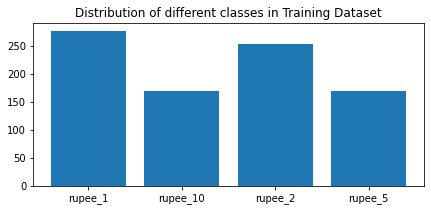

In [ ]:
# plotting a bargraph for train data
plt.figure(figsize=(7,3))
plt.bar(range(len(count_train)), list(count_train.values()), align='center')
plt.xticks(range(len(count_train)),classes)
plt.title('Distribution of different classes in Training Dataset')
plt.show()

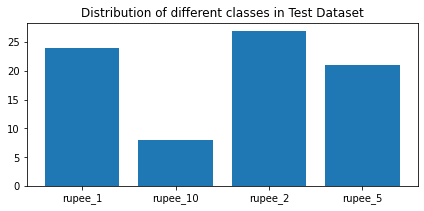

In [ ]:
# plotting a bargraph for test data
plt.figure(figsize=(7,3))
plt.bar(range(len(count_test)), list(count_test.values()), align='center')
plt.xticks(range(len(count_test)), classes)
plt.title('Distribution of different classes in Test Dataset')
plt.show()

So , We have imbalance dataset 

### Plot sample images from each class

In [ ]:
coins_list = [1,2,5,10]

In [ ]:
images_files = []
for i in range(len(coins_list)):
    for j in range(5):
      f = os.listdir(os.path.join(TRAINING_DIR+'/rupee_'+str(coins_list[-i])))[j]
      images_files.append(os.path.join(TRAINING_DIR+'/rupee_'+str(coins_list[-i])+'/'+f))
    

In [ ]:
#images_files

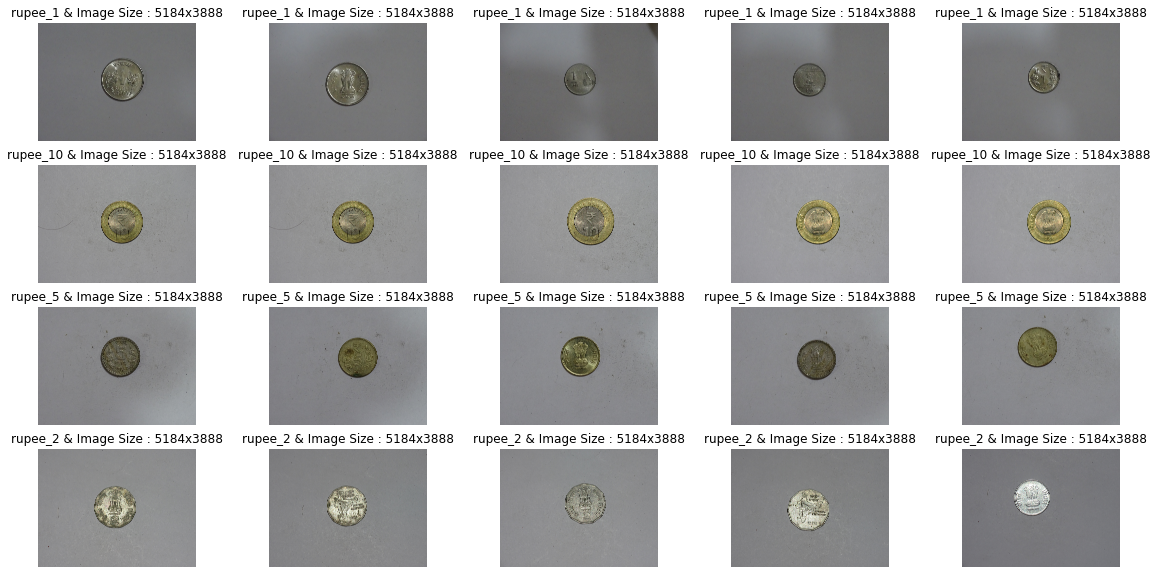

In [ ]:
#plot sample image for each class and image size
from PIL import Image

plt.figure(1, figsize=(20,10))
plt.axis('off')
n = 0
for i in range(len(images_files)):
    n += 1
    #random_img = random.choice(images)
    imgs = imread(images_files[i])
    plt.subplot(4,5, n)
    plt.axis('off')

    im = Image.open(images_files[i])
    w, h = im.size
    img_size = str(w)+'x'+str(h)


    plt.title(os.path.dirname(images_files[i]).split("/")[-1] + " & Image Size : "+img_size)
    plt.imshow(imgs)
    
plt.show()

Images looks to be similar, due to less focus on cois and we have more of white backgroud noise. 
<br>The backside of coinse looks to be similar for coin of rupee 1 and rupee 2 . 
<br>Color of coine of rupee 5 and rupee 10 looks to be some what similar. This features can confuse the model.

# **Data Augmentation**


Data augmentation is used to increase the size of training set and to get more different image. Through Data augmentation we can prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating.

Below image shows transformation on the original image


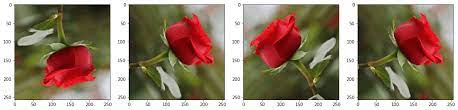

Since We have less number of images , Augumentation would increase size of dataset on fly and help get more accurate results

In [ ]:
def get_datagenerators(TRAINING_DIR,VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
  
    #train and validation dataGenerator 
    train_datagen = ImageDataGenerator( rescale = 1./255, #rescaling factor
                                      rotation_range = 40, #rotates the images by 40 deg
                                      horizontal_flip = True,
                                      fill_mode = 'nearest', # Points to the nearest image
                                      zoom_range = 0.3, #Zoom images 
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.3,
                                      shear_range = 0.2) # Range for shear angle in counter-clockwise direction in degrees


    validation_datagen = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      rotation_range = 40, #rotates the images by 40 deg
                                      fill_mode = 'nearest',
                                      zoom_range = 0.3,
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.3,
                                      shear_range = 0.2) # Range for shear angle in counter-clockwise direction in degrees


    train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size = (IMAGE_SIZE,IMAGE_SIZE),
      class_mode= 'categorical',
      batch_size=BATCH_SIZE
    )

    validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size = (IMAGE_SIZE,IMAGE_SIZE),
      class_mode='categorical',
      batch_size=BATCH_SIZE
    )

    return train_generator, validation_generator

In [ ]:
#for data_batch, labels_batch in train_generator:
    #print('data batch shape:', data_batch.shape)
    #print('labels batch shape:', labels_batch.shape)
    #break

data batch shape: (16, 224, 224, 3)
labels batch shape: (16, 4)


# **CNN Model - Base model From Scratch**

In [ ]:
#define some required variables
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 4

In [ ]:
#clear session 
keras.backend.clear_session()

### Get Datagenerators for specific image and batch size 

In [ ]:
train_generator, validation_generator = get_datagenerators(TRAINING_DIR,VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE)

Found 870 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


### Define model architecture

In [ ]:
#define sequential model architecture
base_model = Sequential([
                   
                    #conv2d+BatchNorm+Pool+Dropout
                    Conv2D(32,(5,5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)), 
                    BatchNormalization(axis=1),
                    Conv2D(64,(5,5),activation='relu'),
                    BatchNormalization(axis=1),
                    Conv2D(64,(5,5),activation='relu'),
                    BatchNormalization(axis=1), 
                    AveragePooling2D(2,2),
                    Dropout(0.5),

                    
                    Conv2D(128,(3,3),activation='relu'),
                    BatchNormalization(axis=1),
                    Conv2D(128,(3,3),activation='relu'),
                    BatchNormalization(axis=1), 
                    AveragePooling2D(2,2),
                    Dropout(0.5),

                    
                    Conv2D(256,(3,3),activation='relu'),
                    BatchNormalization(axis=1), 
                    Conv2D(256,(3,3),activation='relu'),
                    BatchNormalization(axis=1), 
                    AveragePooling2D(2,2),
                    Dropout(0.75),

                    # Fully connected layer and Output layer
                    Flatten(),
                    
                    Dense(512,activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),

                    Dense(128,activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                    
                    Dense(128,activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(NUM_CLASSES,activation='softmax')
                    
                    ])

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 32)      1008      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 64)      51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 248, 248, 64)      992       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 244, 244, 64)      102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 244, 244, 64)      976       
_________________________________________________________________
average_pooling2d (AveragePo (None, 122, 122, 64)      0

### Plot model architecture

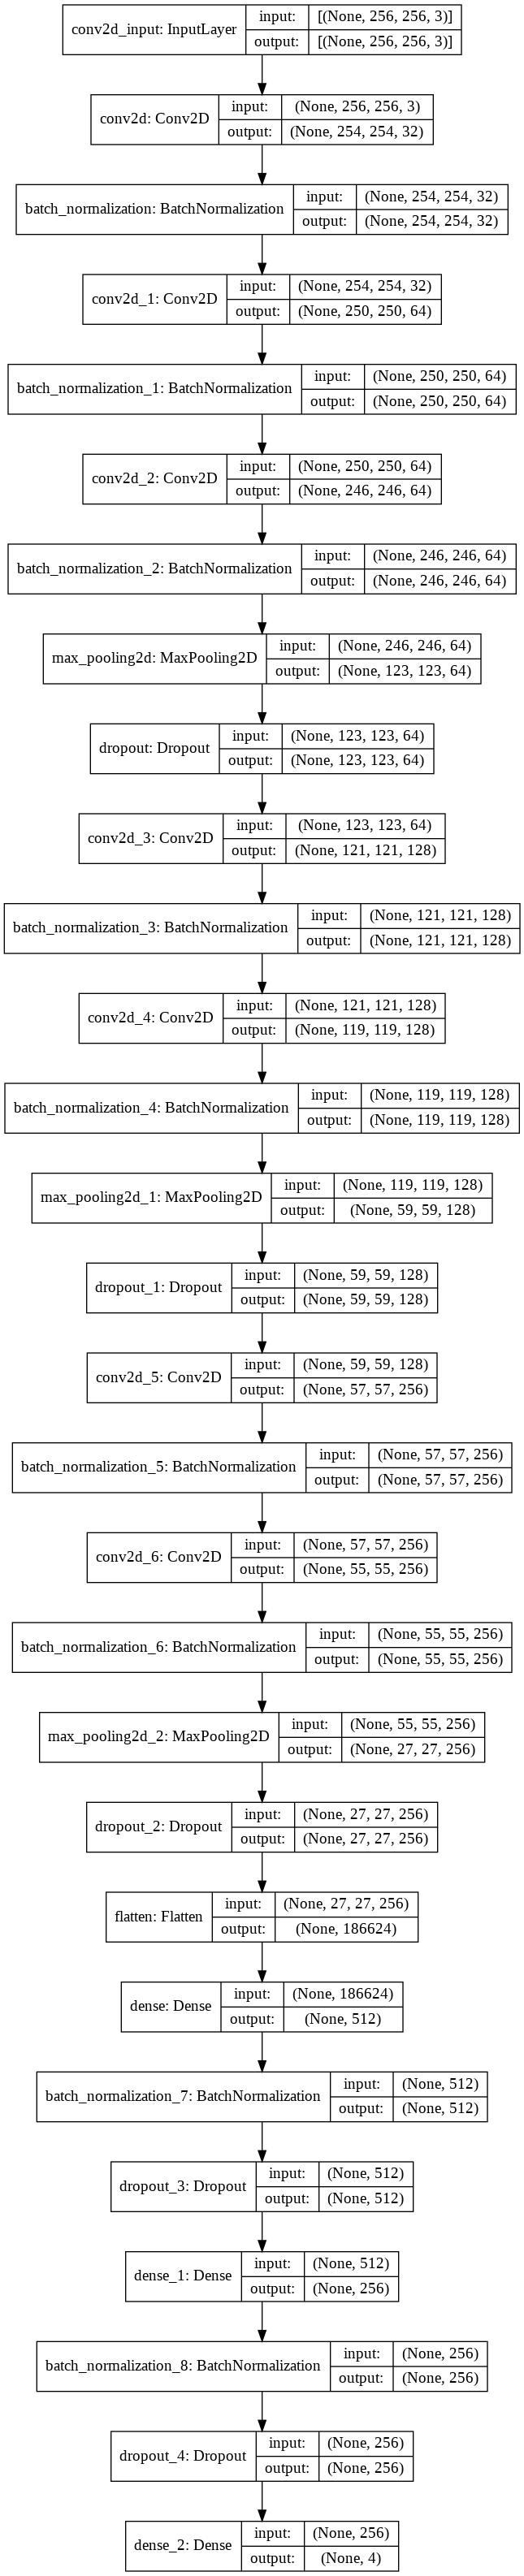

In [ ]:
keras.utils.plot_model(base_model,to_file='/content/output/plots/Base_model_from_Scratch.png',show_shapes=True)

### Define Callbacks

In [ ]:
#define Callbacks

#early stopping if accuracy not improved for 3 epochs
Early = EarlyStopping(monitor = 'val_accuracy',
                      patience = 3,
                      mode = 'max',
                      verbose = 1)


filepath = os.path.join(OUTPUT_DIR,'best_weights_baseModel.hdf5')

checkpoint_model   = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', # model with maximum val_accuracy is saved
                                save_best_only=True, 
                                verbose = 1)

callback_list = [Early, checkpoint_model]


### Compile and Train  model 

In [ ]:
#compile and train of the model

base_model.compile(optimizer=Adam(),
                   metrics = ['accuracy'],
                   loss = 'categorical_crossentropy')

baseModel_history = base_model.fit(train_generator,
                                   validation_data = validation_generator,
                                   batch_size = BATCH_SIZE,
                                   epochs = 25 ,
                                   callbacks = callback_list,
                                   verbose = 1)

Epoch 1/25
55/55 [==============================] - 645s 11s/step - loss: 1.7890 - accuracy: 0.3356 - val_loss: 128.4075 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/output/best_weights_baseModel.hdf5
Epoch 2/25
55/55 [==============================] - 233s 4s/step - loss: 1.7052 - accuracy: 0.3322 - val_loss: 30.1607 - val_accuracy: 0.2625

Epoch 00002: val_accuracy improved from 0.10000 to 0.26250, saving model to /content/output/best_weights_baseModel.hdf5
Epoch 3/25
55/55 [==============================] - 231s 4s/step - loss: 1.5594 - accuracy: 0.3506 - val_loss: 18.5787 - val_accuracy: 0.1000

Epoch 00003: val_accuracy did not improve from 0.26250
Epoch 4/25
55/55 [==============================] - 232s 4s/step - loss: 1.4807 - accuracy: 0.3529 - val_loss: 5.2048 - val_accuracy: 0.1000

Epoch 00004: val_accuracy did not improve from 0.26250
Epoch 5/25
55/55 [==============================] - 233s 4s/step - loss: 1.4027 

As model didnot train well , will make some modifications to model architecture and retrain it 

### Changes to base model 

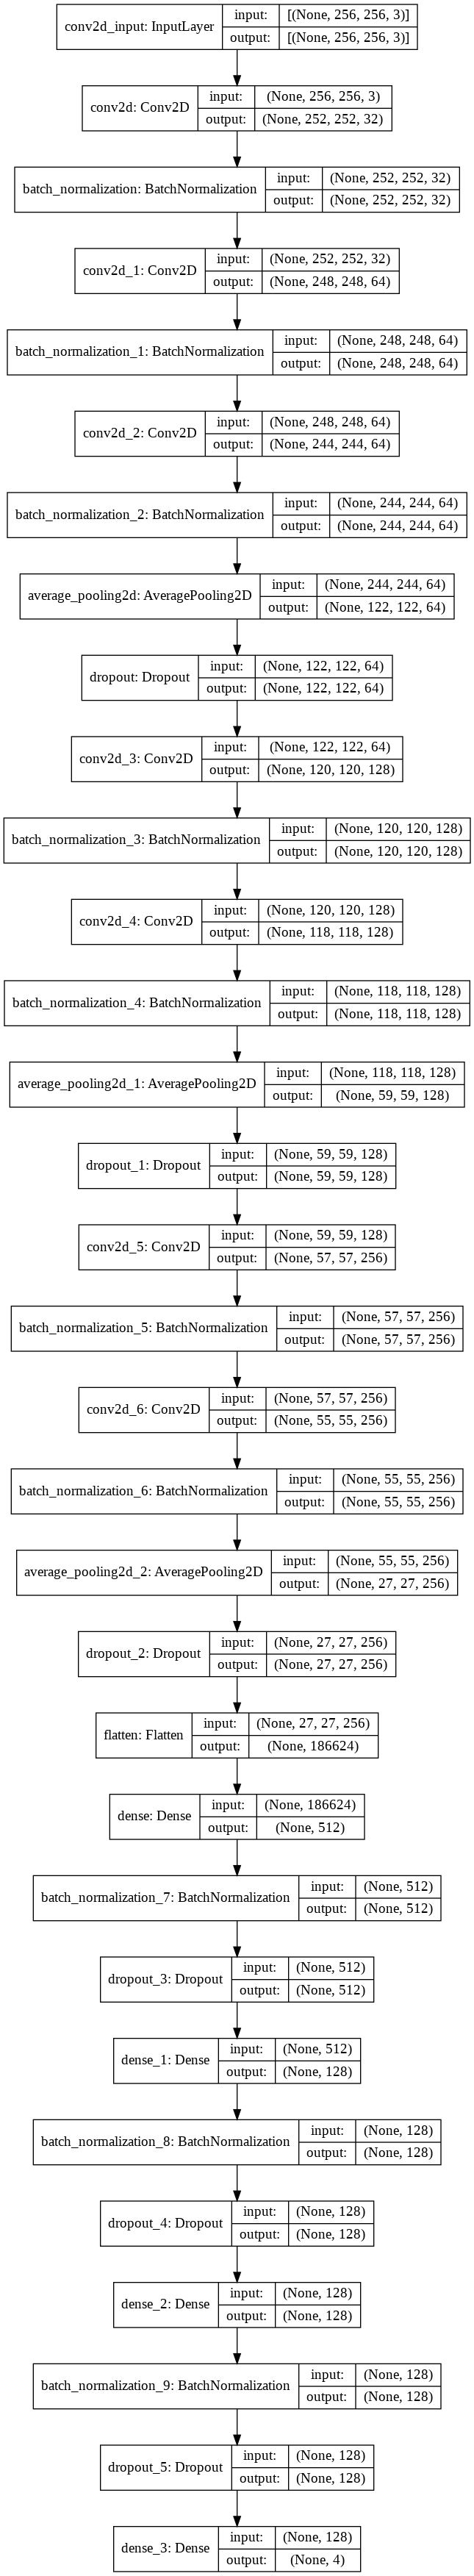

In [ ]:
keras.utils.plot_model(base_model,to_file='/content/output/plots/Base_model_from_Scratch_modified.png',show_shapes=True)

In [ ]:
#compile and train of the model

base_model.compile(optimizer='rmsprop',
                   metrics = ['accuracy'],
                   loss = 'categorical_crossentropy')

baseModel_history = base_model.fit(train_generator,
                                   validation_data = validation_generator,
                                   batch_size = BATCH_SIZE,
                                   epochs = 25 ,
                                   callbacks = callback_list,
                                   verbose = 1)

Epoch 1/25
55/55 [==============================] - 239s 4s/step - loss: 2.1084 - accuracy: 0.3103 - val_loss: 73.0630 - val_accuracy: 0.1000

Epoch 00001: val_accuracy did not improve from 0.26250
Epoch 2/25
55/55 [==============================] - 232s 4s/step - loss: 1.7711 - accuracy: 0.3471 - val_loss: 109.5905 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.26250
Epoch 3/25
55/55 [==============================] - 228s 4s/step - loss: 1.7094 - accuracy: 0.3322 - val_loss: 2.0484 - val_accuracy: 0.3000

Epoch 00003: val_accuracy improved from 0.26250 to 0.30000, saving model to /content/output/best_weights_baseModel.hdf5
Epoch 4/25
55/55 [==============================] - 228s 4s/step - loss: 1.6933 - accuracy: 0.3287 - val_loss: 36.0078 - val_accuracy: 0.1000

Epoch 00004: val_accuracy did not improve from 0.30000
Epoch 5/25
55/55 [==============================] - 228s 4s/step - loss: 1.6060 - accuracy: 0.3402 - val_loss: 12.3747 - val_accuracy: 0.1000



# Transfer Learning 

In [ ]:
keras.backend.clear_session()

## VGG16 

### Model Architecture

In [ ]:
## Adding custom layes to base model

model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
# don't train existing weights 
for layer in model.layers:
  layer.trainable = False

#Adding custom Layers 

x = model.output
x = Flatten()(x)
#Dense layer 1
x = Dense(4096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

#Dense layer2 
x = Dense(4096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

#output layer
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
final_model = models.Model(inputs = model.input, outputs = predictions)



In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Define Callbacks

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2, # if for the past 4 epochs, the accuracy remians constant
                                            factor = 0.6, # decrease the learning rate by 0.6
                                            min_lr = 0.00001)
# Defining Callbacks

filepath = os.path.join(OUTPUT_DIR,'best_weights.hdf5')
checkpoint_model    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', # model with maximum val_accuracy is saved
                                save_best_only=True, 
                                verbose = 1)

callback_list = [learning_rate_reduction, checkpoint_model]




### Compile Model

In [ ]:
#compilation of the model

final_model.compile(optimizer=Adam(), # one of the best optimisers
              loss='categorical_crossentropy', 
              metrics = ['accuracy']) # performance metrics used

### Train Model

In [ ]:
#fit the model 
final_model.fit(train_generator,
                epochs=15,
                batch_size=16,
                validation_data=validation_generator,
                callbacks=callback_list,
                verbose=1)

Epoch 1/15
55/55 [==============================] - 634s 11s/step - loss: 3.6070 - accuracy: 0.3678 - val_loss: 21.1279 - val_accuracy: 0.3125

Epoch 00001: val_accuracy improved from -inf to 0.31250, saving model to /content/output/best_weights.hdf5
Epoch 2/15
55/55 [==============================] - 242s 4s/step - loss: 2.1138 - accuracy: 0.4540 - val_loss: 12.3534 - val_accuracy: 0.3000

Epoch 00002: val_accuracy did not improve from 0.31250
Epoch 3/15
55/55 [==============================] - 228s 4s/step - loss: 1.9031 - accuracy: 0.4954 - val_loss: 4.7011 - val_accuracy: 0.3375

Epoch 00003: val_accuracy improved from 0.31250 to 0.33750, saving model to /content/output/best_weights.hdf5
Epoch 4/15
55/55 [==============================] - 245s 4s/step - loss: 1.9468 - accuracy: 0.5161 - val_loss: 5.7557 - val_accuracy: 0.3875

Epoch 00004: val_accuracy improved from 0.33750 to 0.38750, saving model to /content/output/best_weights.hdf5
Epoch 5/15
55/55 [=============================

Missed statement to save model training history . But from the epochs history above we can see model is getting overfitted.

loss: 1.0550 - accuracy: 0.6471 - val_loss: 1.7782 - val_accuracy: 0.5375

In [ ]:
##increase dropout rate

model1 = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
# don't train existing weights 
for layer in model1.layers:
  layer.trainable = False

#Adding custom Layers 

x = model1.output
x = Flatten()(x)
#Dense layer 1
x = Dense(4096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)

#Dense layer2 
x = Dense(4096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)

#output layer
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
final_model1 = models.Model(inputs = model1.input, outputs = predictions)

#compilation of the model

final_model1.compile(optimizer=Adam(), # one of the best optimisers
              loss='categorical_crossentropy', 
              metrics = ['accuracy']) # performance metrics used

In [ ]:
#fit the model 
history1 = final_model1.fit(train_generator,
                epochs=10,
                steps_per_epoch = np.ceil(len(train_generator) // 16)
                batch_size=16,
                validation_data=validation_generator,
                callbacks=callback_list,
                verbose=1)

Epoch 1/10
55/55 [==============================] - 240s 4s/step - loss: 4.0847 - accuracy: 0.3080 - val_loss: 13.3363 - val_accuracy: 0.2875

Epoch 00001: val_accuracy improved from -inf to 0.28750, saving model to /content/output/best_weights.hdf5
Epoch 2/10
55/55 [==============================] - 242s 4s/step - loss: 3.5171 - accuracy: 0.3770 - val_loss: 5.6710 - val_accuracy: 0.3625

Epoch 00002: val_accuracy improved from 0.28750 to 0.36250, saving model to /content/output/best_weights.hdf5
Epoch 3/10
55/55 [==============================] - 243s 4s/step - loss: 3.0631 - accuracy: 0.4184 - val_loss: 5.0015 - val_accuracy: 0.2875

Epoch 00003: val_accuracy did not improve from 0.36250
Epoch 4/10
55/55 [==============================] - 236s 4s/step - loss: 2.6668 - accuracy: 0.4437 - val_loss: 4.3103 - val_accuracy: 0.4000

Epoch 00004: val_accuracy improved from 0.36250 to 0.40000, saving model to /content/output/best_weights.hdf5
Epoch 5/10
55/55 [==============================]

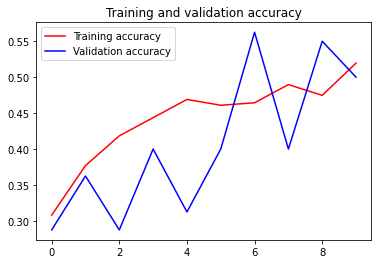

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#fit the model 
history2 = final_model1.fit(train_generator,
                epochs=10,
                batch_size=16,
                validation_data=validation_generator,
                callbacks=callback_list,
                verbose=1)

Epoch 1/10
55/55 [==============================] - 244s 4s/step - loss: 1.9531 - accuracy: 0.5057 - val_loss: 1.5610 - val_accuracy: 0.4250

Epoch 00001: val_accuracy did not improve from 0.56250
Epoch 2/10
55/55 [==============================] - 236s 4s/step - loss: 1.7586 - accuracy: 0.5345 - val_loss: 1.0096 - val_accuracy: 0.5375

Epoch 00002: val_accuracy did not improve from 0.56250
Epoch 3/10
55/55 [==============================] - 237s 4s/step - loss: 1.8483 - accuracy: 0.5333 - val_loss: 1.1023 - val_accuracy: 0.5375

Epoch 00003: val_accuracy did not improve from 0.56250
Epoch 4/10
55/55 [==============================] - 235s 4s/step - loss: 1.6871 - accuracy: 0.5425 - val_loss: 1.2030 - val_accuracy: 0.4500

Epoch 00004: val_accuracy did not improve from 0.56250
Epoch 5/10
55/55 [==============================] - 236s 4s/step - loss: 1.5926 - accuracy: 0.5678 - val_loss: 0.8627 - val_accuracy: 0.5500

Epoch 00005: val_accuracy did not improve from 0.56250
Epoch 6/10
55/5

## InceptionResNetV2

### Define Model architecture

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
m = InceptionResNetV2()
m.summary()

225222656/225209952 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________

In [ ]:
IMAGE_SIZE = 300
BATCH_SIZE = 16 

train_generator1 , validation_generator1 = get_datagenerators(TRAINING_DIR,VALIDATION_DIR,300,16)

Found 870 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [ ]:
keras.backend.clear_session()

In [ ]:
#import 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


#define base model 
model_ResNet = InceptionResNetV2(include_top = False,
                          weights = 'imagenet',
                          input_tensor = None,
                          input_shape = (300,300, 3))

#freeze all layers
for layer in model_ResNet.layers:
  layer.trainable = False



#Adding custom Layers 
x = model_ResNet.output

x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
#Dense layer 1
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#Dense layer2 
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

#output layer
predictions = Dense(NUM_CLASSES, activation="softmax")(x)

# creating the final model 
final_model_resNet = Model(inputs = model_ResNet.input, outputs = predictions)

#compilation of the model

final_model_resNet.compile(optimizer=Adam(), # one of the best optimisers
              loss='categorical_crossentropy', 
              metrics = ['accuracy']) # performance metrics used

In [ ]:
final_model_resNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#keras.utils.plot_model(final_model_resNet,to_file='/content/output/plots/InceptionResNetV2_1.png',show_shapes=True)

#graph is too large for cairo-renderer bitmaps.

### Define callbacks

In [ ]:
## Defining Callbacks
learning_rate_reduction_1 = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2, # if for the past 4 epochs, the accuracy remians constant
                                            factor = 0.5, # decrease the learning rate by 0.6
                                            min_lr = 0.00001)


filepath = os.path.join(OUTPUT_DIR,'best_weights_resNet.hdf5')
checkpoint_model_1    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', # model with maximum val_accuracy is saved
                                save_best_only=True, 
                                verbose = 1)

callback_list_1 = [learning_rate_reduction_1, checkpoint_model_1]


### Train Model 

In [ ]:
history3 = final_model_resNet.fit(train_generator1,
                epochs=40,
                batch_size=16,
                validation_data=validation_generator1,
                callbacks=callback_list_1,
                verbose=1)



Epoch 1/40
55/55 [==============================] - 260s 4s/step - loss: 1.4980 - accuracy: 0.5552 - val_loss: 4.8428 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to /content/output/best_weights_resNet.hdf5
Epoch 2/40
55/55 [==============================] - 234s 4s/step - loss: 1.0691 - accuracy: 0.6414 - val_loss: 2.6358 - val_accuracy: 0.6125

Epoch 00002: val_accuracy improved from 0.37500 to 0.61250, saving model to /content/output/best_weights_resNet.hdf5
Epoch 3/40
55/55 [==============================] - 231s 4s/step - loss: 0.8915 - accuracy: 0.6690 - val_loss: 3.0947 - val_accuracy: 0.5750

Epoch 00003: val_accuracy did not improve from 0.61250
Epoch 4/40
55/55 [==============================] - 230s 4s/step - loss: 0.9263 - accuracy: 0.6862 - val_loss: 1.9320 - val_accuracy: 0.4500

Epoch 00004: val_accuracy did not improve from 0.61250
Epoch 5/40
55/55 [==============================] - 227s 4s/step - loss: 0.7541 - accuracy:

In [ ]:
final_model_resNet.evaluate(validation_generator1)

5/5 [==============================] - 32s 6s/step - loss: 0.8707 - accuracy: 0.6875


[0.8706604242324829, 0.6875]

In [ ]:
# loading the best model
final_model_resNet.load_weights(filepath)

In [ ]:
final_model_resNet.evaluate(validation_generator1)

5/5 [==============================] - 33s 7s/step - loss: 0.7023 - accuracy: 0.7250


[0.7022783756256104, 0.7250000238418579]

### Plot Model train History 

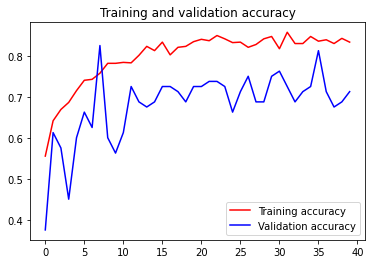

<Figure size 432x288 with 0 Axes>

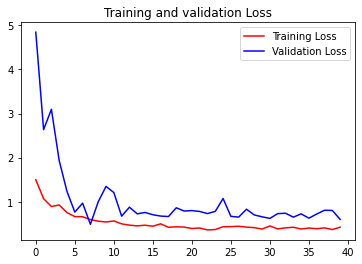

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

We acheived 72% accuracy score on validation data . We saved model with best score and will use further to evaluate the results on unseen data 

In [ ]:
final_model_resNet.save('resnet.h5')

### Predictions on unseen data 

In [ ]:
!pip install gradio -q

     |████████████████████████████████| 3.6 MB 5.0 MB/s 
     |████████████████████████████████| 206 kB 60.5 MB/s 
     |████████████████████████████████| 1.9 MB 42.8 MB/s 
     |████████████████████████████████| 961 kB 44.6 MB/s 
     |████████████████████████████████| 3.5 MB 50.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [ ]:
train_generator1.class_indices

{'rupee_1': 0, 'rupee_10': 1, 'rupee_2': 2, 'rupee_5': 3}

In [ ]:
import gradio as gr

model = load_model('resnet.h5')

try:
  #used model trained using vgg16 as it performed well on both train and test data
  labels = ['rupee_1','rupee_10','rupee_2','rupee_5'] #classes

  def classify_image(inp):
    img = inp.reshape((-1,300,300,3)) #reshape input image
    prediction = model.predict(img).flatten() #prediction
    return {labels[i]: float(prediction[i]) for i in range(len(labels))} #return classes

  image = gr.inputs.Image(shape=(300,300))
  label = gr.outputs.Label(num_top_classes=1)

  gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch(debug=True,share=True)

except KeyboardInterrupt:
      # do nothing here
      pass

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://26427.gradio.app


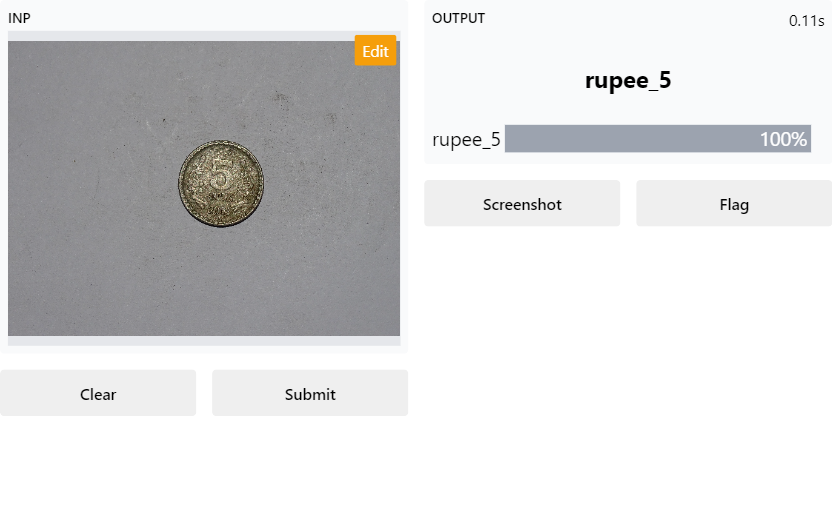

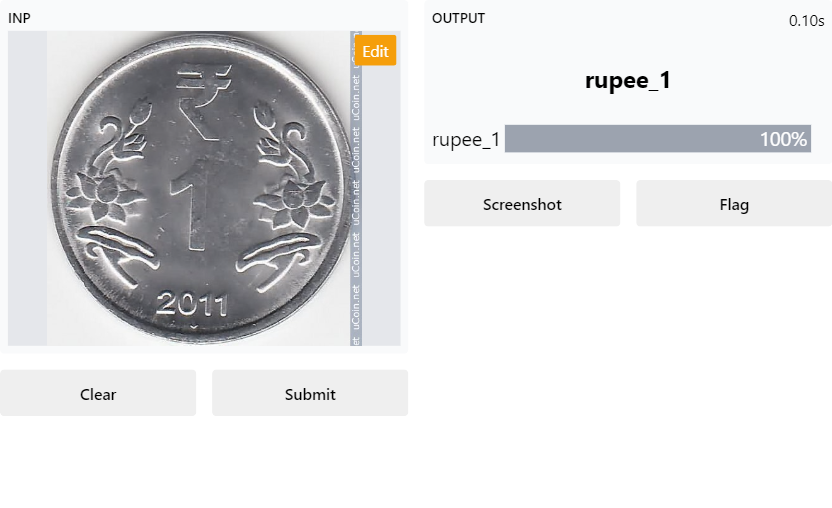

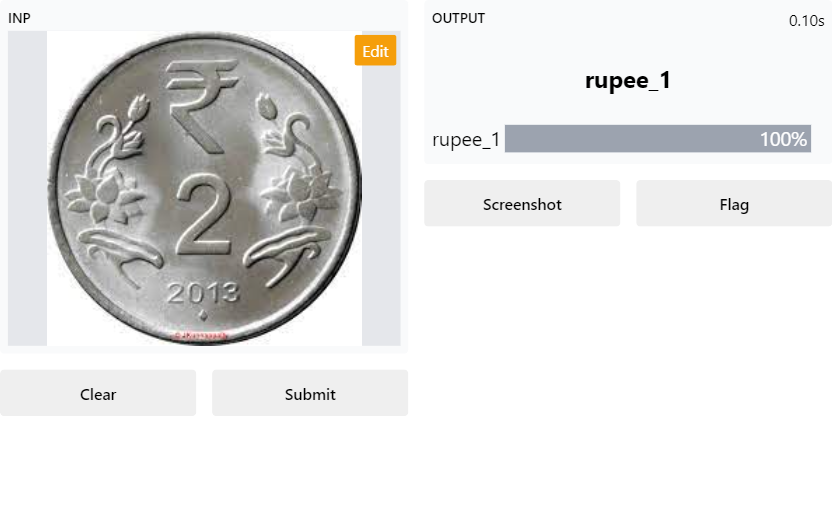

MOdel is getting confused with coin of rupee 1 and coin 2 

## Modfiying InceptionResNetV2 

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


model_ResNet1 = InceptionResNetV2(include_top = False,
                          weights = 'imagenet',
                          input_tensor = None,
                          input_shape = (300,300, 3))

for layer in model_ResNet1.layers:
  layer.trainable = False



#Adding custom Layers 

x = model_ResNet1.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
#Dense layer 1
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)

#output layer
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
final_model_resNet2 = models.Model(inputs = model_ResNet1.input, outputs = predictions)

#compilation of the model

final_model_resNet2.compile(optimizer=Adam(learning_rate=0.002), # one of the best optimisers
              loss='categorical_crossentropy', 
              metrics = ['accuracy']) # performance metrics used

In [ ]:
learning_rate_reduction_1 = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2, # if for the past 4 epochs, the accuracy remians constant
                                            factor = 0.5, # decrease the learning rate by 0.6
                                            min_lr = 0.00001)
# Defining Callbacks

filepath = os.path.join(OUTPUT_DIR,'best_weights_resNet_1.hdf5')
checkpoint_model_1    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', # model with maximum val_accuracy is saved
                                save_best_only=True, 
                                verbose = 1)

callback_list_1 = [learning_rate_reduction_1, checkpoint_model_1]

In [ ]:
history4 = final_model_resNet2.fit(train_generator1,
                epochs=10,
                batch_size=16,
                validation_data=validation_generator1,
                callbacks=callback_list_1,
                verbose=1)

final_model_resNet2.load_weights(filepath)

Epoch 1/10
55/55 [==============================] - 271s 5s/step - loss: 1.4512 - accuracy: 0.5425 - val_loss: 2.3911 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/output/best_weights_resNet_1.hdf5
Epoch 2/10
55/55 [==============================] - 245s 4s/step - loss: 0.9798 - accuracy: 0.6310 - val_loss: 2.4807 - val_accuracy: 0.4625

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/10
55/55 [==============================] - 239s 4s/step - loss: 0.8107 - accuracy: 0.6747 - val_loss: 1.1193 - val_accuracy: 0.6125

Epoch 00003: val_accuracy improved from 0.50000 to 0.61250, saving model to /content/output/best_weights_resNet_1.hdf5
Epoch 4/10
55/55 [==============================] - 238s 4s/step - loss: 0.7747 - accuracy: 0.6701 - val_loss: 0.8418 - val_accuracy: 0.5875

Epoch 00004: val_accuracy did not improve from 0.61250
Epoch 5/10
55/55 [==============================] - 238s 4s/step - loss: 0.7064 - accur

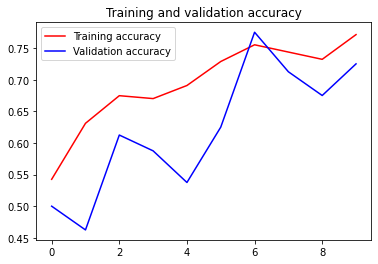

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
final_model_resNet2.save('Resnet_2.h5')

After some changes in number of neuron units and dense layers we acheived 77% accuray. 
<br>
5% improvement , this can be improve more further with increase in number of epochs and increase in dataset size.

<br> Model is getting confused with the coins backside that needs to be improved.